Importando bibliotecas necessárias.

In [2]:
%pip install trimesh
import os
import glob
import trimesh
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
tf.random.set_seed(1234)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 709.0/709.0 kB 47.1 MB/s eta 0:00:00


GPU

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs disponiveis: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs disponiveis:  1


DATASET

In [7]:
DATA_DIR = tf.keras.utils.get_file(
    "modelnet.zip",
    "https://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip",
    extract=True,
)
DATA_DIR = "/root/.keras/datasets/modelnet_extracted/ModelNet10"

In [12]:
DATA_DIR = "/root/.keras/datasets/modelnet_extracted/ModelNet10"


Test de MESH

In [13]:
mesh = trimesh.load(os.path.join(DATA_DIR, "chair/train/chair_0001.off"))
mesh.show()

Mesh Simples

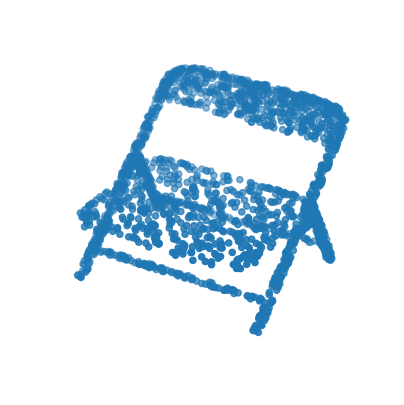

In [17]:
points = mesh.sample(2048)

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:,0], points[:,1], points[:,2])
ax.set_axis_off()
plt.show()

Parse Data/interpretando dados

In [24]:
def parse_data(num_points=2048):
  train_points = []
  train_labels = []
  test_points = []
  test_labels = []
  class_map = {}
  folders = glob.glob(os.path.join(DATA_DIR, "[!README]*"))

  for i, folder in enumerate(folders):
    print("processando classe: {}".format(os.path.basename(folder)))
    class_map[i]=(folder.split("/")[-1])
    train_files = glob.glob(os.path.join(folder, "train/*"))
    test_files = glob.glob(os.path.join(folder, "test/*"))

    for f in train_files:
      train_points.append(trimesh.load(f).sample(num_points))
      train_labels.append(i)

    for f in test_files:
      test_points.append(trimesh.load(f).sample(num_points))
      test_labels.append(i)

  return (
      np.array(train_points),
      np.array(test_points),
      np.array(train_labels),
      np.array(test_labels),
      class_map,
  )

Interpretando dados e processando cada classe

In [25]:
NUM_POINTS = 2048
NUM_CLASSES = 10
NUM_BATCHES = 32

train_points, test_points, train_labels, test_labels, CLASS_MAP = parse_data(NUM_POINTS)

processando classe: bathtub
processando classe: dresser
processando classe: sofa
processando classe: monitor
processando classe: bed
processando classe: night_stand
processando classe: table
processando classe: desk
processando classe: chair
processando classe: toilet


Augmentation

In [48]:
def augment(points, label):
    # Converte para float32 se ainda estiver em float64
    points = tf.cast(points, tf.float32)

    # Aplica ruído
    points += tf.random.uniform(tf.shape(points), -0.005, 0.005, dtype=tf.float32)

    # Embaralha os pontos
    points = tf.random.shuffle(points)

    # Garante que o label esteja em int32
    label = tf.cast(label, tf.int32)

    return points, label


train_dataset = tf.data.Dataset.from_tensor_slices((train_points, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_points, test_labels))

train_dataset = train_dataset.shuffle(len(train_points)).map(augment).batch(NUM_BATCHES)
test_dataset = test_dataset.shuffle(len(test_points)).batch(NUM_BATCHES)

Funções para construir o modelo

In [49]:
def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)


def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

In [50]:
class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
      self.num_features = num_features
      self.l2reg = l2reg
      self.eye = tf.eye(num_features)

    def __call__(self, x):
      x = tf.reshape(x, (-1, self.num_features, self.num_features))
      xxt = tf.tensordot(x, x, axes=(1, 2))
      xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
      return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))

T-net Layers

In [51]:
def tnet(input, num_features):
    #bias = keras.initializers.Constant(np.eye(num_features).flatten())
    bias = keras.initializers.Constant(np.eye(num_features, dtype=np.float32).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = conv_bn(input, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    return layers.Dot(axes=(2, 1))([input, feat_T])

Criando a rede convolucional

In [52]:
input = keras.Input(shape=(NUM_POINTS, 3))

x = tnet(input, 3)
x = conv_bn(x, 32)
x = conv_bn(x, 32)
x = tnet(x, 32)
x = conv_bn(x, 64)
x = conv_bn(x, 512)
x = layers.GlobalMaxPooling1D()(x)
x = dense_bn(x, 256)
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 128)
x = layers.Dropout(0.3)(x)

output = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs=input, outputs=output, name="pointnet")
model.summary()

Model: "pointnet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 2048, 3)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_18 (Conv1D)  │ (None, 2048, 32)  │        128 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2048, 32)  │        128 │ conv1d_18[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_28       │ (None, 2048, 32)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_19 (Conv1D)  │ (None, 2048, 64)  │      2,112 │ activation_28[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2048, 64)  │        256 │ conv1d_19[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_29       │ (None, 2048, 64)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_20 (Conv1D)  │ (None, 2048, 512) │     33,280 │ activation_29[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2048, 512) │      2,048 │ conv1d_20[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_30       │ (None, 2048, 512) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ activation_30[0]… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 256)       │    131,328 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_15[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_31       │ (None, 256)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 128)       │     32,896 │ activation_31[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_16[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_32       │ (None, 128)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 9)         │      1,161 │ activation_32[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_4 (Reshape) │ (None, 3, 3)      │          0 │ dense_17[0][0]  

 Total params: 747,795 (2.85 MB)

 Trainable params: 741,779 (2.83 MB)

 Non-trainable params: 6,016 (23.50 KB)

Compilando e treinando o modelo

In [53]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)


model.fit(train_dataset, epochs=20, validation_data=test_dataset)

Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 38s 133ms/step - loss: 44.6445 - sparse_categorical_accuracy: 0.2569 - val_loss: 5698599115554816.0000 - val_sparse_categorical_accuracy: 0.2269
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 19s 43ms/step - loss: 36.3527 - sparse_categorical_accuracy: 0.3255 - val_loss: 10210.7744 - val_sparse_categorical_accuracy: 0.1993
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - loss: 36.0502 - sparse_categorical_accuracy: 0.3434 - val_loss: 1726093590528.0000 - val_sparse_categorical_accuracy: 0.2148
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - loss: 36.0289 - sparse_categorical_accuracy: 0.3683 - val_loss: 1841279.2500 - val_sparse_categorical_accuracy: 0.1244
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - loss: 35.8489 - sparse_categorical_accuracy: 0.4007 - val_loss: 4712309456896.0000 - val_sparse_categorical_accuracy: 0.2081
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - loss: 35.7991 - sparse_categorical_accuracy: 0.42

Visualizando os resultados

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


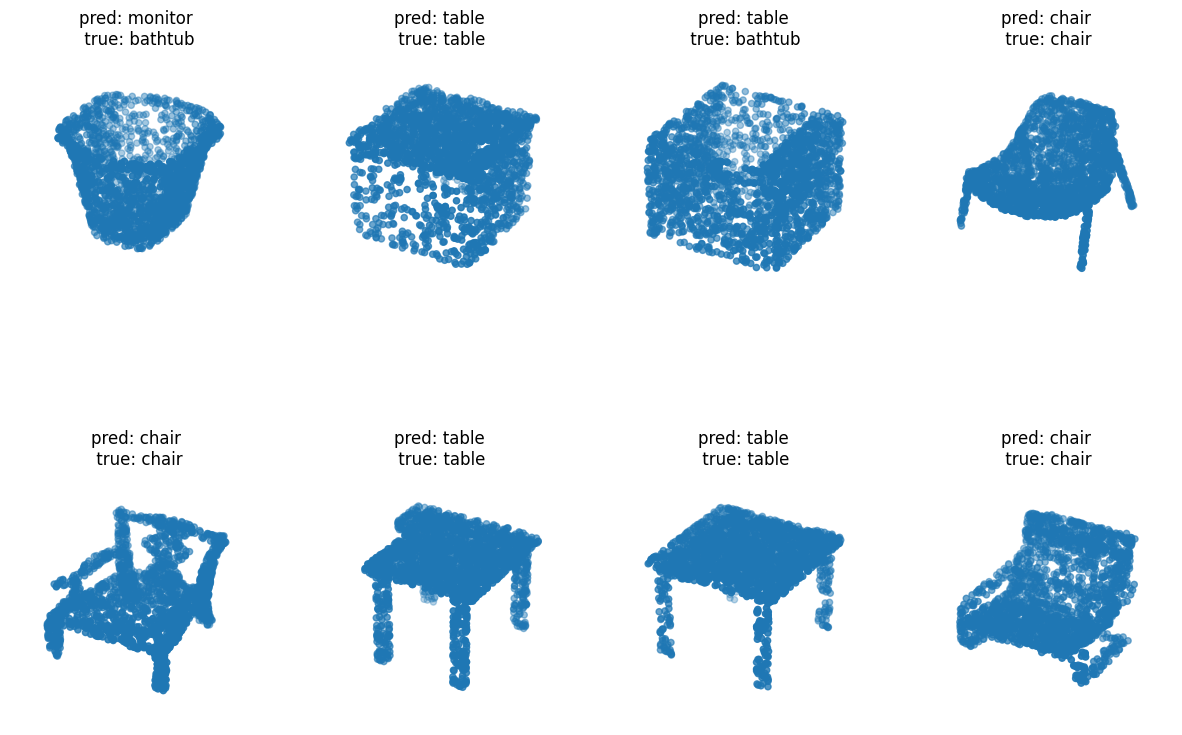

In [54]:
data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

# predição
preds = model.predict(points)
preds = tf.math.argmax(preds, -1)

points = points.numpy()

fig = plt.figure(figsize=(15, 10))

for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {}\n true: {}".format(
            CLASS_MAP[preds[i].numpy()], CLASS_MAP[labels.numpy()[i]]
        )
    )
    ax.set_axis_off()
plt.show()